In [1]:
# Some libraries
from scipy import *
from math import *
from matplotlib.pyplot import *
from functools import *
import sys
from tqdm import tqdm

In [2]:
from sympy.geometry import Point
from sympy.geometry import Polygon as SimpyPolygon
import math
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import pyclipper
import functools

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

## Class and converting functions

In [3]:
class Rectangle:
    """Minimal representation of a rectangle"""
    def __init__(self, point1_x, point1_y, point2_x, point2_y, longueur):
        self.point1_x = point1_x
        self.point1_y = point1_y
        self.point2_x = point2_x
        self.point2_y = point2_y
        self.longueur = longueur

In [4]:
def sol_to_rect(solution):
    """Convert a minimal rectangle to a SimpyPolygon rectangle"""
    if type(solution) != Rectangle:
        solution = Rectangle(*solution)
    point1 = Point(solution.point1_x, solution.point1_y)
    point2 = Point(solution.point2_x, solution.point2_y)
    if point1.equals(point2):
        raise ValueError("Point 1 and point 2 are the same")
    if solution.longueur == 0:
        raise ValueError("Longueur nulle interdite")
    longueur = solution.longueur
    vect = (point2.x - point1.x, point2.y - point1.y)
    distance = point1.distance(point2)
    vectUnitaire = (vect[0] / distance * longueur, vect[1] / distance * longueur)
    normalVect = (-vectUnitaire[1], vectUnitaire[0])
    point3 = Point(point2.x + normalVect[0], point2.y + normalVect[1])
    point4 = Point(point1.x + normalVect[0], point1.y + normalVect[1])
    return SimpyPolygon(point1, point2, point3, point4)

In [5]:
def path_to_polygon(path):
    """Return a polygon if it is not one yet"""
    if type(path) == list:
        return SimpyPolygon(*path)
    return path

def polygon_to_path(polygon):
    """Return a path if it is not one yet"""
    if type(polygon) == SimpyPolygon:
        return list(map(lambda p: [p.x, p.y], polygon.vertices))
    return polygon

## Drawing functions

In [6]:
def draw_polygon(polygon, ax=None, color="green"):
    """Draw a polygon over an axis (not shown directly)
    
    @param polygon: Whether a polygon or a path
    """
    if ax is None:
        ax = plt.gca()
    if type(polygon) == SimpyPolygon:
        polygon = np.array(list(map(lambda p: [p.x, p.y], polygon.vertices)))
    p = Polygon(polygon, closed=False, color=color, alpha=0.3)
    ax.add_patch(p)
    ax.axis('equal')
    return ax

In [25]:
def draw_polygons(polygons, colors=None, verbose=False):
    """Draw polygons and print the figure
    
    @param polygons: SimpyPolygon or list(SimpyPolygon)
    @param colors: colors to match to the polygons
    """
    ax = plt.gca()
    if type(polygons) == SimpyPolygon:
        polygons = [polygons]
    if colors is None:
        colors = ["grey"]*len(polygons)
    if len(colors) > 0 and len(colors) < len(polygons):
        colors = colors + [colors[-1]] * (len(polygons) - len(colors))
    colors.reverse()
    
    for polygon in polygons:
        color = colors.pop()
        if verbose:
            print(color, "Polygon : ", polygon)
        ax = draw_polygon(polygon, ax, color=color)
    plt.show()

## Calculate the area of a polygon

In [60]:
def area(polygon):
    print("entrée: area")
    try:
        if type(polygon) == SimpyPolygon:
            res = abs(polygon.area)
            print("sortie: area")
            return res
        #print("In area : ", polygon)
        #print("In area : ", abs(float((sol_to_rect(polygon)).area)))
        poly = sol_to_rect(polygon)
        
        res = abs(float((sol_to_rect(polygon)).area))
        print("sortie: area")
        return res
    except:
        printmd("### Error !")
        print(polygon)

def get_bornage_search_field(polygon):
    polygon = polygon_to_path(polygon)
    min_func = lambda acc, vertice: min(min(*vertice),acc)
    max_func = lambda acc, vertice: max(max(*vertice),acc)
    
    min_search_field = functools.reduce(min_func, polygon, sys.maxsize)
    max_search_field = functools.reduce(max_func, polygon, -sys.maxsize)
    
    return min_search_field, max_search_field
    

## Calculate the validity of a solution

In [48]:
def vertice_in_polygon(vertice, polygon):
    """ Determine if the vertice is in the polygon
    Not a strict check because of the pyclipper library in which
    the coordinates are floored.
    """
    return list(map(lambda c: int(c), vertice)) in polygon

def est_valide(rectangle, polygon):
    """ Determine if the rectangle is in the polygon
    
    @param rectangle: whether a polygon or a list of vertices
    @param polygon: whether a polygon or a list of vertices
    """
    print("entrée: est_valide")
    try:
        rectangle, polygon = polygon_to_path(rectangle), polygon_to_path(polygon)
        pc = pyclipper.Pyclipper()
        pc.AddPath(polygon, pyclipper.PT_SUBJECT, True)
        pc.AddPath(rectangle, pyclipper.PT_CLIP, True)
    
        intersections = pc.Execute(pyclipper.CT_INTERSECTION, pyclipper.PFT_EVENODD, pyclipper.PFT_EVENODD)
        
        res = (intersections != []) and (len(intersections[0]) == len(rectangle)) and np.all([vertice_in_polygon(v, intersections[0]) for v in rectangle]) 
        return res, intersections
    except pyclipper.ClipperException:
        print("Clipper exception")
        return False

House : Polygon(Point2D(12, 66), Point2D(38, 37), Point2D(1334*sqrt(1517)/1517 + 38, 1196*sqrt(1517)/1517 + 37), Point2D(12 + 1334*sqrt(1517)/1517, 1196*sqrt(1517)/1517 + 66))
Land : Polygon(Point2D(0, 0), Point2D(0, 100), Point2D(100, 100), Point2D(110, 50), Point2D(100, 0))


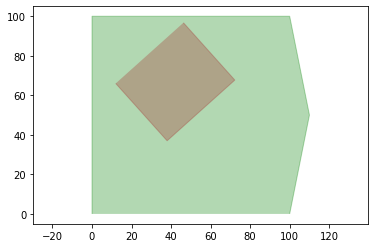

entrée: est_valide


### Validité : C'est bon ça passe

entrée: area
entrée: area


### L'aire de la maison est de **1791** m² sur 10500 m² possible



green Polygon :  Polygon(Point2D(0, 0), Point2D(0, 100), Point2D(100, 100), Point2D(110, 50), Point2D(100, 0))
brown Polygon :  Polygon(Point2D(12, 66), Point2D(38, 37), Point2D(1334*sqrt(1517)/1517 + 38, 1196*sqrt(1517)/1517 + 37), Point2D(12 + 1334*sqrt(1517)/1517, 1196*sqrt(1517)/1517 + 66))
blue Polygon :  [[72, 67], [46, 96], [12, 66], [38, 37]]


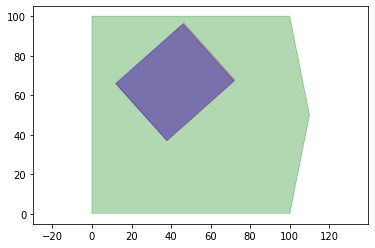

In [49]:
solution = Rectangle(*[12, 66, 38, 37, 46])
house = sol_to_rect(solution)
print("House :", house)

land = SimpyPolygon((0,0), (0,100), (100,100), (110, 50), (100, 0))
print("Land :", land)

# draw the situation
draw_polygons([land, house], colors=["green", "brown"], verbose=False)

# determine if the house is well placed over the land
res, clip = est_valide(house, land)
printmd("### Validité : C'est bon ça passe" if res else "### Validité : Noooooooon, construction incorrecte")
printmd(f"### L'aire de la maison est de **{int(area(house))}** m² sur {area(land)} m² possible\n\n")

# draw the solution to verify it is correct
draw_polygons([land, house, clip[0]], colors=["green","brown","blue"], verbose=True)

In [11]:
get_bornage_search_field(land)

(0, 110)

In [51]:
def polygon_bornage(sol, land_polygon):
    print("entrée: polygon_bornage")
    rect = sol_to_rect(sol)
    if est_valide(rect, land_polygon):
        print(sol)
        printmd("## Est valide")
        return sol 
    else:
        print("this one is invaid")
        print(sol)
        raise ValueError("Solution invalide par contrainte de bornage")

In [53]:
# inf, sup = get_bornage_search_field(land)
# PSO_fit(eval_function=area, 
#         bornage_function=lambda x: polygon_bornage(x, land), 
#         log_function=lambda x:draw_polygons([land, sol_to_rect(x)], colors=["green", "brown"]), 
#         nb_particle=20, 
#         dim=5, inf=inf, sup=sup, 
#         nb_cycles=3)

entrée: area
4586.60600835587


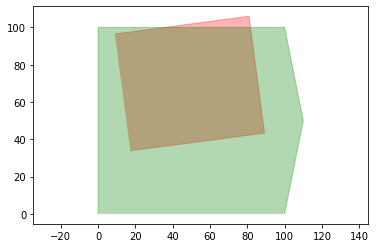

In [54]:
sol = [17.238688824344802, 33.826900857585485, 89.20655264720808, 43.35993743447405, 63.179434758583284]
print(area(sol))
draw_polygons(polygons=[sol_to_rect(sol), land], colors=["red", "green"])

In [15]:
Nb_cycles = 2000
Nb_particle = 20
# usual params
psi,cmax = (0.7, 1.47) 
# psi,cmax = (0.8, 1.62)

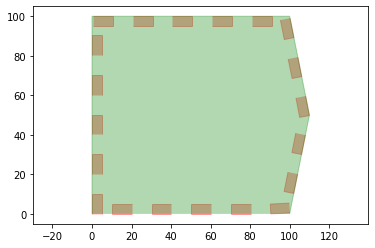

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


In [16]:
from sympy import Symbol
def pick_random_sol(land, size=1, delta=0.05, stochastic=False):
    t = Symbol('t', real=True)
    p = land.arbitrary_point('t')
    if stochastic:
        picks = sorted([random.rand() for i in range(size*2)])
    else:
        picks = np.linspace(0, 1, size*2+1)
    points_on_perimeter = [p.subs(t, pick) for pick in picks]
    #picks = [pick + delta if pick + delta < 1 else pick + (1 - pick) / 2 for pick in picks]
    #second_points_on_perimeter = [p.subs(t, pick) for pick in picks]
    return [[points_on_perimeter[i*2].x, points_on_perimeter[i*2].y, points_on_perimeter[i*2+1].x, points_on_perimeter[i*2+1].y, -delta*100] for i in range(size)]
    # return p.subs(t, (s1 + s2/2)/perimeter)
sols = [sol_to_rect(sol) for sol in pick_random_sol(land, 20)]
draw_polygons([*sols, land], colors=["red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "green"])
print([est_valide(sol, land)[0] for sol in sols])

In [55]:
# Initialization

# create a particle 
# one particle is discribed by : 
#   - pos : solution list of variables
#   - vit : movement velocity (null at the initialization)
#   - fit :  fitness of the solution
#   - bestpos : best visited position 
#   - bestfit : evaluation of the best visited solution
#   - bestvois : best neighbor (global for this version)
# def initOne(dim,inf,sup, eval_func=FUNCTION):
#     pos = [random.uniform(inf, sup) for i in range(dim)]
#     fit = eval(pos, eval_func)
#     return {'vit':[0]*dim, 'pos':pos, 'fit':fit, 'bestpos':pos, 'bestfit':fit, 'bestvois':[]}


# Init of the population (swarm)
def initSwarm(nb,dim,eval_func,land=None):
    print("entrée: initSwarm")
    #return [initOne(dim,inf,sup) for i in range(nb)]
    positions = pick_random_sol(land, nb)
    fits = [eval_func(pos) for pos in positions]
    print("sortie: initSwarm")
    return [{'vit':[0]*dim, 'pos':positions[i], 'fit':fits[i], 'bestpos':positions[i], 'bestfit':fits[i], 'bestvois':[]} for i in range(nb)]

In [56]:
# Return the particle with the best fitness
def maxParticle(p1,p2):
    if (p1["fit"] > p2["fit"]):
        return p1 
    else:
        return p2

# Returns a copy of the particle with the best fitness in the population
def getBest(swarm):
    return dict(reduce(lambda acc, e: maxParticle(acc,e),swarm[1:],swarm[0]))

In [57]:
# Update information for the particles of the population (swarm)
def update(particle,bestParticle):
    nv = dict(particle)
    if(particle["fit"] > particle["bestfit"]):
        nv['bestpos'] = particle["pos"][:]
        nv['bestfit'] = particle["fit"]
    nv['bestvois'] = bestParticle["bestpos"][:]
    return nv

# Calculate the velocity and move a particule
def move(particle, dim, eval_function, bornage_function):
    global ksi,c1,c2,psi,cmax

    print("entrée: move")
    nv = dict(particle)

    velocity = [0]*dim
    for i in range(dim):
        velocity[i] = (particle["vit"][i]*psi + \
        cmax*random.uniform()*(particle["bestpos"][i] - particle["pos"][i]) + \
        cmax*random.uniform()*(particle["bestvois"][i] - particle["pos"][i]))

    new_pos = [particle["pos"][i] + velocity[i] for i in range(dim)]
    try:
        position = bornage_function(new_pos)
    except ValueError:
        print("Debug: ", new_pos, "is an incorrect solution")
        position = particle["pos"]

    nv['vit'] = velocity
    nv['pos'] = position
    nv['fit'] = eval_function(position)

    print("sortie: move")
    return nv

In [58]:
# MAIN LOOP
LAND = land
def fit(eval_function, bornage_function, nb_particle=Nb_particle, dim=5, nb_cycles=Nb_cycles, log_function=print):
    Htemps = []       # temps
    Hbest = []        # distance

    # initialization of the population
    swarm = initSwarm(nb_particle,dim,eval_func=eval_function, land=LAND)
    draw_polygons([land]+[sol_to_rect(sol["pos"]) for sol in swarm], colors=["green", "red"])
    # initialization of the best solution
    best = getBest(swarm)
    best_cycle = best

    for i in tqdm(range(nb_cycles)):
        #Update informations
        swarm = [update(e,best_cycle) for e in swarm]
        # velocity calculations and displacement
        swarm = [move(particle=e, dim=dim, eval_function=eval_function, bornage_function=bornage_function) for e in swarm]
        draw_polygons([land]+[sol_to_rect(sol["pos"]) for sol in swarm], colors=["green", "red"])
        # Update of the best solution
        best_cycle = getBest(swarm)
        if (best_cycle["bestfit"] > best["bestfit"]):
            best = best_cycle
            # draw(best['pos'], best['fit'])

        # historization of data
        if i % 10 == 0:
            Htemps.append(i)
            Hbest.append(best['bestfit'])
            
        log_function(best['pos'])

    # END, displaying results
    Htemps.append(i)
    Hbest.append(best['bestfit'])

    #displaying result on the console
    dispRes(best)

In [62]:
fit(eval_function=area, 
    bornage_function=lambda x: polygon_bornage(x, land), 
    log_function=lambda x:draw_polygons([land, sol_to_rect(x)], colors=["green", "brown"]),
    nb_particle=5, 
    dim=5, 
    nb_cycles=200)

entrée: initSwarm


KeyboardInterrupt: 